<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/2D_shape_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

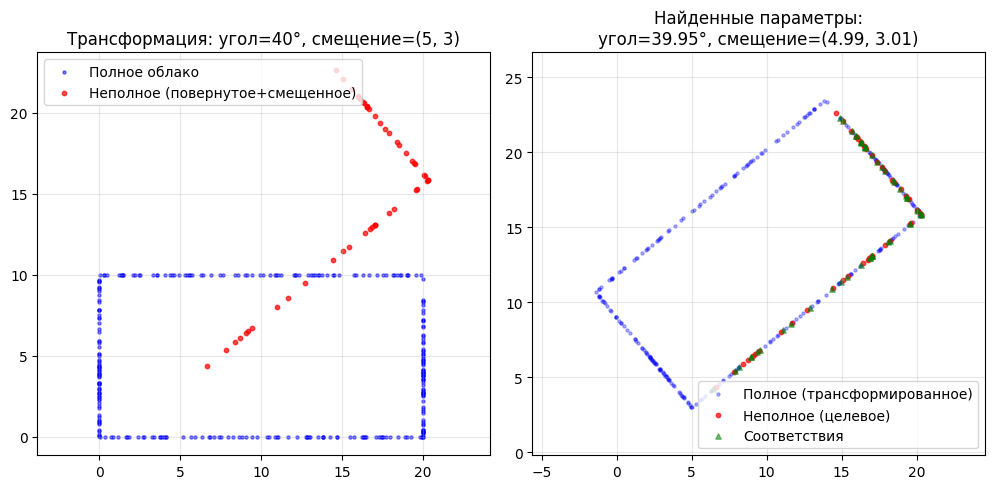

Истинные параметры:
  Угол: 40°
  Смещение: (5, 3)

Найденные параметры:
  Угол: 39.95°
  Смещение: (4.99, 3.01)

Ошибка выравнивания: 0.093874
Точек в полном облаке: 300
Точек в неполном облаке: 50


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.optimize import minimize

def generate_lidar_points(width, height, n_points):
    """Генерирует случайные точки на периметре прямоугольника"""

    n_per_side = n_points // 4
    remainder = n_points % 4

    points = []

    # Нижняя сторона (y=0)
    x_bottom = np.random.uniform(0, width, n_per_side + (remainder > 0))
    points.extend(np.column_stack([x_bottom, np.zeros_like(x_bottom)]))

    # Правая сторона (x=width)
    y_right = np.random.uniform(0, height, n_per_side + (remainder > 1))
    points.extend(np.column_stack([np.full_like(y_right, width), y_right]))

    # Верхняя сторона (y=height)
    x_top = np.random.uniform(0, width, n_per_side + (remainder > 2))
    points.extend(np.column_stack([x_top, np.full_like(x_top, height)]))

    # Левая сторона (x=0)
    y_left = np.random.uniform(0, height, n_per_side)
    points.extend(np.column_stack([np.zeros_like(y_left), y_left]))

    return np.array(points)

def transform_points(points, angle, translation):
    """Поворачивает и смещает точки"""
    # Поворот
    rad = np.radians(angle)
    rot = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
    rotated = points @ rot.T
    # Смещение
    return rotated + translation

# Параметры
width, height = 20, 10
n_points_full = 300
n_points_incomplete = 100

# Генерация облаков точек
full_cloud = generate_lidar_points(width, height, n_points_full)
incomplete_cloud = generate_lidar_points(width, height, n_points_incomplete)[:50]  # только часть точек

# Трансформация неполного облака (поворот + смещение)
true_angle = 40
true_translation = np.array([5, 3])
incomplete_transformed = transform_points(incomplete_cloud, true_angle, true_translation)

def alignment_error(params):
    """Ошибка выравнивания для заданных параметров трансформации"""
    angle, tx, ty = params
    transformed_full = transform_points(full_cloud, angle, np.array([tx, ty]))
    tree = KDTree(transformed_full)
    distances = tree.query(incomplete_transformed)[0]
    return np.mean(distances)

# Поиск оптимальных параметров
result = minimize(
    alignment_error,
    x0=[0, 0, 0],  # начальное приближение
    bounds=[(-180, 180), (-20, 20), (-20, 20)],  # границы поиска
    method='L-BFGS-B'
)

best_angle, best_tx, best_ty = result.x
best_translation = np.array([best_tx, best_ty])

# Визуализация
plt.figure(figsize=(15, 5))

# 1. Исходные облака
plt.subplot(131)
plt.scatter(full_cloud[:, 0], full_cloud[:, 1], c='blue', s=5, alpha=0.5, label='Полное облако')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='red', s=10, alpha=0.7, label='Неполное (повернутое+смещенное)')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Трансформация: угол={true_angle}°, смещение=({true_translation[0]}, {true_translation[1]})')

# 2. После трансформации неполного облака
plt.subplot(132)
transformed_full = transform_points(full_cloud, best_angle, best_translation)
plt.scatter(transformed_full[:, 0], transformed_full[:, 1], c='blue', s=5, alpha=0.3, label='Полное (трансформированное)')
plt.scatter(incomplete_transformed[:, 0], incomplete_transformed[:, 1],
           c='red', s=10, alpha=0.7, label='Неполное (целевое)')

# Находим соответствия
tree = KDTree(transformed_full)
distances, indices = tree.query(incomplete_transformed)
plt.scatter(transformed_full[indices, 0], transformed_full[indices, 1],
           c='green', s=15, alpha=0.5, marker='^', label='Соответствия')

plt.axis('equal')
plt.grid(alpha=0.3)
plt.legend()
plt.title(f'Найденные параметры:\nугол={best_angle:.2f}°, смещение=({best_tx:.2f}, {best_ty:.2f})')

plt.tight_layout()
plt.show()

print("Истинные параметры:")
print(f"  Угол: {true_angle}°")
print(f"  Смещение: ({true_translation[0]}, {true_translation[1]})")
print("\nНайденные параметры:")
print(f"  Угол: {best_angle:.2f}°")
print(f"  Смещение: ({best_tx:.2f}, {best_ty:.2f})")
print(f"\nОшибка выравнивания: {alignment_error(result.x):.6f}")
print(f"Точек в полном облаке: {len(full_cloud)}")
print(f"Точек в неполном облаке: {len(incomplete_transformed)}")